# CS6120 Assignment 1 Part 1

Sanjiv Motilal Choudhari

# 1. Implement BPE Algorithm

In [1]:
from collections import defaultdict, Counter
from typing import List, Dict, Tuple, Set
import re

class BPETokenizer:
    def __init__(self, vocab_size: int):
        self.vocab_size = vocab_size
        self.vocab = set()  # To store the final vocabulary
        self.merges = {}    # To Store the merge rules learned during training

    def get_stats(self, words: List[List[str]]) -> Counter:
        pairs = Counter()
        for word in words:
            for i in range(len(word) - 1):
                pairs[tuple(word[i:i + 2])] += 1
        return pairs

    def merge_vocab(self, words: List[List[str]], pair: Tuple[str, str]) -> List[List[str]]:
        new_words = []
        bigram = re.escape(' '.join(pair))
        pattern = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
        replacement = ''.join(pair)

        for word in words:
            w = ' '.join(word)
            w = pattern.sub(replacement, w)
            new_words.append(w.split())

        return new_words

    def fit(self, texts: List[str]) -> None:
        words = [[c for c in text] for text in texts] # Splitting text into characters with word boundaries

        self.vocab = set(char for word in words for char in word) # Adding all characters to initial vocabulary

        while len(self.vocab) < self.vocab_size:  # Learn the merge rules until the target vocab size is reached
            # Counting pair frequencies
            pair_freq = self.get_stats(words)
            if not pair_freq:
                break

            best_pair = max(pair_freq.items(), key=lambda x: x[1])[0] # Obtaining the most frequent pair

            self.vocab.add(''.join(best_pair))  # Add merged tokens to vocabulary

            self.merges[best_pair] = ''.join(best_pair) # Store merge rule

            words = self.merge_vocab(words, best_pair) # Apply this merge rule to all words

    def tokenize(self, text: str) -> List[str]:
        # Start with characters
        word = [c for c in text]

        # Applying merge rules iteratively
        while True:
            pairs = self.get_stats([word])
            if not pairs:
                break

            # Find mergeable pair with the highest frequency
            bigram = max(pairs.items(), key=lambda x: x[1])[0]

            # Stop if can't merge any more
            if bigram not in self.merges:
                break

            # Apply the merge
            word = self.merge_vocab([word], bigram)[0]

        return word

    def encode(self, texts: List[str]) -> List[List[str]]:
       return [self.tokenize(text) for text in texts]

# 2. Train on NLTK Dataset

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


Loaded and preprocessed: austen-emma.txt
Text length: 877180 characters
Loaded and preprocessed: blake-poems.txt
Text length: 35916 characters
Loaded and preprocessed: shakespeare-hamlet.txt
Text length: 158019 characters

Training BPE...

Final vocabulary size: 1000
Number of merge rules learned: 956


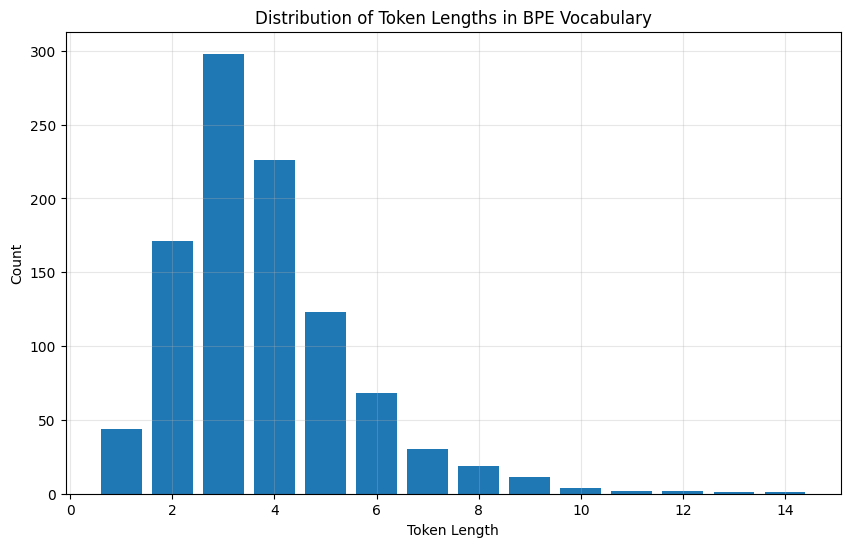


Sample tokens by length:

Length 1: ['s', '6', 'z', '9', '0']

Length 2: ['ob', 'wh', 'oy', 'mr', '."']

Length 3: ['imp', 'ast', 'ell', 'one', 'hal']

Length 4: ['emor', 'jane', 'come', 'thes', 'what']

Length 5: ['riend', 'ought', 'atter', 'about', 'ation']

Length 6: ['letter', 'forher', 'rather', 'person', 'gether']

Length 7: ['withher', 'fairfax', 'wouldbe', 'ishould', 'hadbeen']

Length 8: ['shecould', 'verymuch', 'anything', 'youngman', 'therewas']

Length 9: ['attention', 'mrs.elton', 'missbates', 'churchill', 'something']

Length 10: ['everything', 'mrs.weston', 'understand', 'particular']

Length 11: ['missfairfax', 'janefairfax']

Length 12: ['mr.knightley', 'mr.woodhouse']

Length 13: ['misswoodhouse']

Length 14: ['frankchurchill']

Sample tokenization:
Original: To be, or not to be, that is the question
Tokenized: ['t', 'o', ' ', 'b', 'e', ',', ' ', 'o', 'r', ' ', 'n', 'o', 't', ' ', 't', 'o', ' ', 'b', 'e', ',', ' ', 't', 'h', 'a', 't', ' ', 'i', 's', ' ', 't', 'h', 'e

In [2]:
import nltk
from nltk.corpus import gutenberg
import matplotlib.pyplot as plt
from collections import Counter
import re

nltk.download('gutenberg')

def preprocess_text(text: str) -> str:
    text = text.lower() # Converts to lowercase
    text = re.sub(r'\s+', ' ', text) # Replaces multiple spaces with a single space
    text = re.sub(r'[^a-z0-9\s.,!?\'"-]', '', text) # Removes special characters but keep basic punctuation
    return text.strip()

def load_and_preprocess_books(book_ids: list) -> list:
    texts = []
    for book_id in book_ids:
        raw_text = gutenberg.raw(book_id) # Load raw text
        processed_text = preprocess_text(raw_text) # Preprocess the text
        texts.append(processed_text)
        print(f"Loaded and preprocessed: {book_id}")
        print(f"Text length: {len(processed_text)} characters")
    return texts

training_books = [
    'austen-emma.txt',
    'blake-poems.txt',
    'shakespeare-hamlet.txt'
]

# Loads and preprocesses the training texts
training_texts = load_and_preprocess_books(training_books)

# Initialize BPE tokenizer
vocab_size = 1000
bpe = BPETokenizer(vocab_size)

# Training the BPE on the texts
print("\nTraining BPE...")
bpe.fit(training_texts)

# Analyzing the vocabulary
print(f"\nFinal vocabulary size: {len(bpe.vocab)}")
print(f"Number of merge rules learned: {len(bpe.merges)}")

# Function to analyze token lengths
def analyze_token_lengths(vocab):
    lengths = [len(token) for token in vocab]
    return Counter(lengths)

# Analyzes and visualizes token lengths
token_lengths = analyze_token_lengths(bpe.vocab)

# Plotting token length distribution
plt.figure(figsize=(10, 6))
lengths = list(token_lengths.keys())
counts = list(token_lengths.values())
plt.bar(lengths, counts)
plt.title('Distribution of Token Lengths in BPE Vocabulary')
plt.xlabel('Token Length')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

# Printing sample tokens of different lengths
print("\nSample tokens by length:")
for length in sorted(token_lengths.keys()):
    sample_tokens = [token for token in bpe.vocab if len(token) == length][:5]
    print(f"\nLength {length}: {sample_tokens}")

# Testing tokenization on a sample
sample_text = "To be, or not to be, that is the question"
tokens = bpe.tokenize(sample_text.lower())
print("\nSample tokenization:")
print(f"Original: {sample_text}")
print(f"Tokenized: {tokens}")

# 3. Test on NLTK Dataset

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Testing BPE tokenizer on books...

Processing melville-moby_dick.txt...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Results for melville-moby_dick.txt:
precision: 0.5119
recall: 0.0023
f1_score: 0.0046
jaccard_similarity: 0.0023
coverage: 0.4515
unique_predicted: 84
unique_reference: 18603
book: melville-moby_dick.txt

Processing carroll-alice.txt...
Results for carroll-alice.txt:
precision: 0.3947
recall: 0.0054
f1_score: 0.0106
jaccard_similarity: 0.0053
coverage: 1.3591
unique_predicted: 38
unique_reference: 2796
book: carroll-alice.txt

Processing chesterton-brown.txt...
Results for chesterton-brown.txt:
precision: 0.3506
recall: 0.0034
f1_score: 0.0067
jaccard_similarity: 0.0034
coverage: 0.9641
unique_predicted: 77
unique_reference: 7987
book: chesterton-brown.txt


<ipython-input-3-219b8726f751>:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(books, rotation=45)
<ipython-input-3-219b8726f751>:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(books, rotation=45)
<ipython-input-3-219b8726f751>:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(books, rotation=45)
<ipython-input-3-219b8726f751>:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(books, rotation=45)


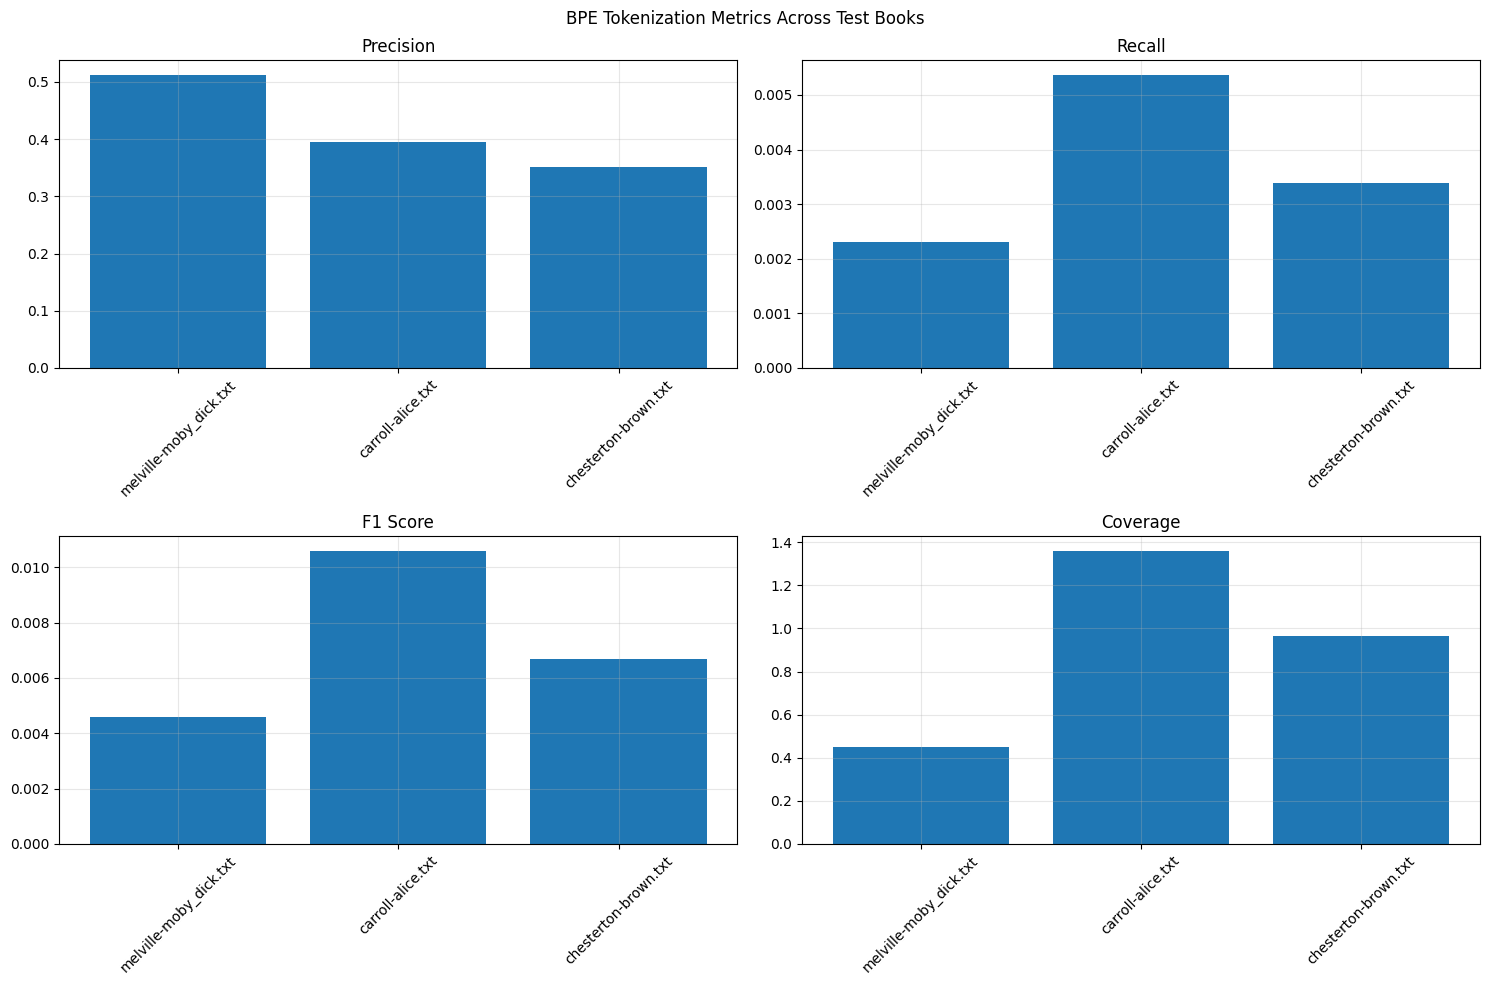

In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import gutenberg
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

nltk.download('gutenberg')
nltk.download('punkt_tab')
nltk.download('punkt')

def evaluate_tokenization(predicted_tokens, reference_tokens):
    # Converts token lists to sets for set operations
    pred_set = set(predicted_tokens)
    ref_set = set(reference_tokens)

    # Calculate the metrics
    true_positives = len(pred_set.intersection(ref_set))
    total_predicted = len(pred_set)
    total_reference = len(ref_set)

    # Calculate the accuracy metrics
    precision = true_positives / total_predicted if total_predicted > 0 else 0
    recall = true_positives / total_reference if total_reference > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate the Jaccard similarity
    jaccard = len(pred_set.intersection(ref_set)) / len(pred_set.union(ref_set))

    # Calculate the coverage
    coverage = len(pred_set) / len(ref_set) * 100

    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'jaccard_similarity': jaccard,
        'coverage': coverage,
        'unique_predicted': len(pred_set),
        'unique_reference': len(ref_set)
    }

def test_bpe_on_books(bpe_tokenizer, test_books):
    nltk.download('punkt')
    results = []

    for book_id in test_books:
        print(f"\nProcessing {book_id}...")

        # Load and preprocess text
        raw_text = gutenberg.raw(book_id)
        processed_text = preprocess_text(raw_text)

        # BPE tokenization
        bpe_tokens = bpe_tokenizer.tokenize(processed_text)

        # NLTK tokenization (reference)
        nltk_tokens = word_tokenize(processed_text)

        # Evaluate tokenization
        metrics = evaluate_tokenization(bpe_tokens, nltk_tokens)
        metrics['book'] = book_id
        results.append(metrics)

        print(f"Results for {book_id}:")
        for metric, value in metrics.items():
            if isinstance(value, float):
                print(f"{metric}: {value:.4f}")
            else:
                print(f"{metric}: {value}")

    return results

# Test books
test_books = [
    'melville-moby_dick.txt',
    'carroll-alice.txt',
    'chesterton-brown.txt'
]

# Run evaluation
print("Testing BPE tokenizer on books...")
evaluation_results = test_bpe_on_books(bpe, test_books)

# Visualize the results
def plot_metrics(results):
    metrics = ['precision', 'recall', 'f1_score', 'coverage']
    books = [r['book'] for r in results]

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('BPE Tokenization Metrics Across Test Books')

    for idx, metric in enumerate(metrics):
        row = idx // 2
        col = idx % 2
        values = [r[metric] for r in results]

        axes[row, col].bar(books, values)
        axes[row, col].set_title(metric.replace('_', ' ').title())
        axes[row, col].set_xticklabels(books, rotation=45)
        axes[row, col].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot the results
plot_metrics(evaluation_results)

# 4. Create Reference Tokenization

In [4]:
from nltk.tokenize import PunktSentenceTokenizer
import json
import os

def create_reference_tokenization(books):
    reference_tokenizations = {}

    # Initialize punkt tokenizer
    punkt = PunktSentenceTokenizer()

    for book_id in books:
        print(f"\nProcessing {book_id} for reference tokenization...")

        # Load and preprocess text
        raw_text = gutenberg.raw(book_id)
        processed_text = preprocess_text(raw_text)

        # Sentence tokenization
        sentences = punkt.tokenize(processed_text)

        # Word tokenization for each sentence
        tokenized_sentences = [word_tokenize(sent) for sent in sentences]

        reference_tokenizations[book_id] = {
            'sentences': sentences,
            'tokens': [token for sent in tokenized_sentences for token in sent]
        }

        print(f"Created reference tokenization for {book_id}")
        print(f"Number of sentences: {len(sentences)}")
        print(f"Number of tokens: {len(reference_tokenizations[book_id]['tokens'])}")

    # Save the reference tokenizations
    os.makedirs('tokenizations', exist_ok=True)
    with open('tokenizations/reference_tokenizations.json', 'w') as f:
        json.dump(reference_tokenizations, f, indent=2)

    return reference_tokenizations

# Create reference tokenizations for test books
reference_tokens = create_reference_tokenization(test_books)


Processing melville-moby_dick.txt for reference tokenization...
Created reference tokenization for melville-moby_dick.txt
Number of sentences: 9930
Number of tokens: 250439

Processing carroll-alice.txt for reference tokenization...
Created reference tokenization for carroll-alice.txt
Number of sentences: 1625
Number of tokens: 32935

Processing chesterton-brown.txt for reference tokenization...
Created reference tokenization for chesterton-brown.txt
Number of sentences: 3704
Number of tokens: 84365


# 5. Compare with Standard Tokenization


Comparing tokenizations for melville-moby_dick.txt...

Comparing tokenizations for carroll-alice.txt...

Comparing tokenizations for chesterton-brown.txt...

Tokenization Comparison:
+------------------------+--------------+--------------+---------------+---------------+-------------------+-------------------+
| Book                   |   BPE Tokens |   BPE Unique |   NLTK Tokens |   NLTK Unique |   Treebank Tokens |   Treebank Unique |
+========================+==============+==============+===============+===============+===================+===================+
| melville-moby_dick.txt |       689006 |           84 |        250320 |         18603 |            243030 |             21177 |
+------------------------+--------------+--------------+---------------+---------------+-------------------+-------------------+
| carroll-alice.txt      |       111614 |           38 |         32933 |          2796 |             31774 |              3189 |
+------------------------+--------------+-

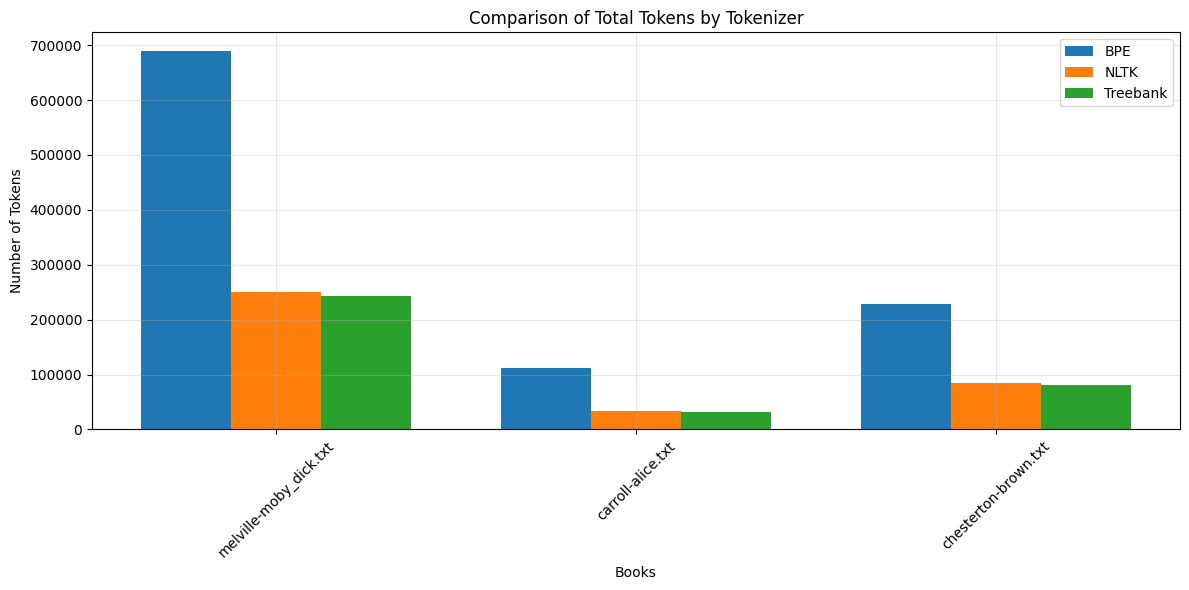

In [5]:
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from tabulate import tabulate

def compare_tokenizations(test_books, bpe_tokenizer):
    comparison_results = []

    # Initialize tokenizers
    treebank = TreebankWordTokenizer()

    for book_id in test_books:
        print(f"\nComparing tokenizations for {book_id}...")

        # Load and preprocess text
        raw_text = gutenberg.raw(book_id)
        processed_text = preprocess_text(raw_text)

        # Get tokenizations
        bpe_tokens = bpe_tokenizer.tokenize(processed_text)
        nltk_tokens = word_tokenize(processed_text)
        treebank_tokens = treebank.tokenize(processed_text)

        # Calculate statistics
        stats = {
            'book': book_id,
            'bpe_tokens': len(bpe_tokens),
            'bpe_unique': len(set(bpe_tokens)),
            'nltk_tokens': len(nltk_tokens),
            'nltk_unique': len(set(nltk_tokens)),
            'treebank_tokens': len(treebank_tokens),
            'treebank_unique': len(set(treebank_tokens))
        }

        comparison_results.append(stats)

    # Create comparison table
    headers = ['Book', 'BPE Tokens', 'BPE Unique', 'NLTK Tokens',
              'NLTK Unique', 'Treebank Tokens', 'Treebank Unique']
    table_data = [[r['book'], r['bpe_tokens'], r['bpe_unique'],
                  r['nltk_tokens'], r['nltk_unique'],
                  r['treebank_tokens'], r['treebank_unique']]
                 for r in comparison_results]

    print("\nTokenization Comparison:")
    print(tabulate(table_data, headers=headers, tablefmt='grid'))

    return comparison_results

# Run comparison
comparison_results = compare_tokenizations(test_books, bpe)

# Visualize comparison
def plot_comparison(results):
    books = [r['book'] for r in results]

    # Plot total tokens
    plt.figure(figsize=(12, 6))
    x = np.arange(len(books))
    width = 0.25

    plt.bar(x - width, [r['bpe_tokens'] for r in results], width, label='BPE')
    plt.bar(x, [r['nltk_tokens'] for r in results], width, label='NLTK')
    plt.bar(x + width, [r['treebank_tokens'] for r in results], width, label='Treebank')

    plt.xlabel('Books')
    plt.ylabel('Number of Tokens')
    plt.title('Comparison of Total Tokens by Tokenizer')
    plt.xticks(x, books, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot comparison
plot_comparison(comparison_results)

# 6. Vizualisation (Learning Process)

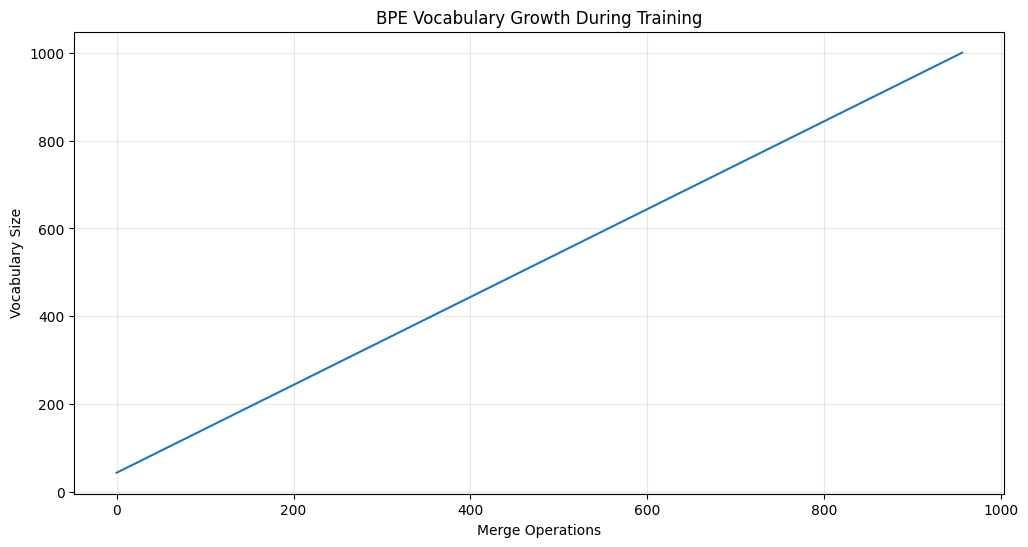

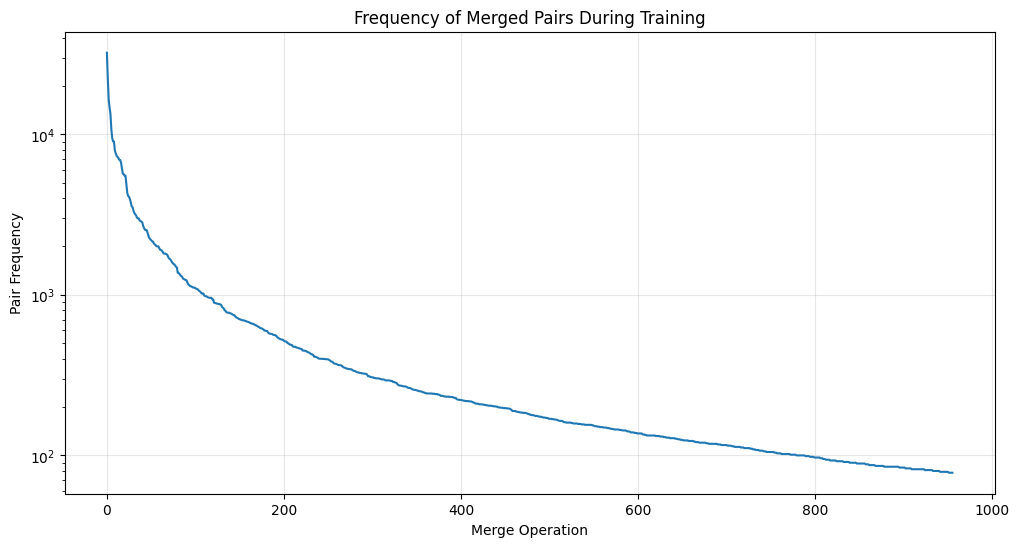


Most frequent merges:
Pair: ('e', ' '), Frequency: 32198
Pair: ('t', 'h'), Frequency: 22205
Pair: ('e', 'r'), Frequency: 16481
Pair: ('i', 'n'), Frequency: 14735
Pair: ('a', 'n'), Frequency: 13395
Pair: ('o', 'u'), Frequency: 10741
Pair: ('t', 'o'), Frequency: 9457
Pair: ('e', 's'), Frequency: 9016
Pair: ('e', 'n'), Frequency: 9004
Pair: ('o', 'n'), Frequency: 7900


In [6]:
class BPETokenizerWithViz(BPETokenizer):
    def __init__(self, vocab_size):
        super().__init__(vocab_size)
        self.merge_history = []
        self.vocab_growth = []

    def fit(self, texts):
        # Split texts into characters with word boundaries
        words = [[c for c in text] for text in texts]

        # Add all characters to initial vocabulary
        self.vocab = set(char for word in words for char in word)
        self.vocab_growth.append(len(self.vocab))

        while len(self.vocab) < self.vocab_size:
            # Count pair frequencies
            pair_freq = self.get_stats(words)
            if not pair_freq:
                break

            # Get most frequent pair
            best_pair = max(pair_freq.items(), key=lambda x: x[1])[0]
            freq = pair_freq[best_pair]

            # Store merge information
            self.merge_history.append({
                'pair': best_pair,
                'freq': freq,
                'vocab_size': len(self.vocab)
            })

            # Add merged token to vocabulary
            self.vocab.add(''.join(best_pair))

            # Store merge rule
            self.merges[best_pair] = ''.join(best_pair)

            # Apply merge rule to all words
            words = self.merge_vocab(words, best_pair)

            # Track vocabulary growth
            self.vocab_growth.append(len(self.vocab))

def visualize_bpe_learning(bpe_viz):
    # Plot vocabulary growth
    plt.figure(figsize=(12, 6))
    plt.plot(bpe_viz.vocab_growth)
    plt.title('BPE Vocabulary Growth During Training')
    plt.xlabel('Merge Operations')
    plt.ylabel('Vocabulary Size')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Plot merge frequencies
    plt.figure(figsize=(12, 6))
    freqs = [m['freq'] for m in bpe_viz.merge_history]
    plt.plot(freqs)
    plt.title('Frequency of Merged Pairs During Training')
    plt.xlabel('Merge Operation')
    plt.ylabel('Pair Frequency')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Show most frequent merges
    print("\nMost frequent merges:")
    sorted_merges = sorted(bpe_viz.merge_history, key=lambda x: x['freq'], reverse=True)
    for merge in sorted_merges[:10]:
        print(f"Pair: {merge['pair']}, Frequency: {merge['freq']}")

# Train BPE with visualization
bpe_viz = BPETokenizerWithViz(vocab_size=1000)
bpe_viz.fit(training_texts)

# Visualize learning process
visualize_bpe_learning(bpe_viz)

In [11]:
import nltk
nltk.download('gutenberg')
import os
import shutil
from nltk.corpus import gutenberg
os.makedirs('gutenberg_books', exist_ok=True)

training_books = [
       'austen-emma.txt',
       'blake-poems.txt',
       'shakespeare-hamlet.txt'
   ]

test_books = [
       'melville-moby_dick.txt',
       'carroll-alice.txt',
       'chesterton-brown.txt'
   ]

all_books = training_books + test_books

for book_id in all_books:
    with open(os.path.join('gutenberg_books', book_id), 'w') as f:
        f.write(gutenberg.raw(book_id))

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
